This example will show how to generate the Markov chain-based analysis from [1] using the MindScoPy package

In [72]:
import mindscopy as ms
from preprocessing.artifact_removal import peak_rejection, riemannian_potato_rejection
from preprocessing.misc import epoch
from preprocessing.rebias import apply_rebias_to_groups
from preprocessing.feature_extraction import ScaledTangentSpace
import numpy as np
import pyriemann
import pickle


In [73]:
# load the preprocessed (bandpass filtered and epoched) BCI Competition IV 2a data
with open('data/BCI_Comp_IV_2a/preprocessed_data.pkl', 'rb') as f:
    d = pickle.load(f)


In [171]:
# select data from one person
p = 9

# Extract all data from both sessions
X = np.concatenate([d[p][1]['trials'], d[p][2]['trials']])
y = np.concatenate([d[p][1]['labels'], d[p][2]['labels']])
blocks = np.concatenate([
    d[p][1]['run_labels'], 
    d[p][2]['run_labels']+(1+max(d[p][1]['run_labels'])) # shift the second session's block labels
])


Perform the preprocessing steps of artifact rejecting and sub-epoching.

In [172]:
print(X.shape)
print(np.unique(y))

(501, 22, 1501)
[1 2 3 4]


In [173]:
# split trials into rest and task epochs
Fs = 250
length = 3 * Fs
stride = 3 * Fs
X = epoch(X, length, stride)
Xtask = X[:,1,:,:]
Xrest = X[:,0,:,:]
y_rest = np.zeros((Xrest.shape[0],))

# concatenate rest and task epochs
X = np.concatenate([Xtask, Xrest])
y = np.concatenate([y, y_rest])
blocks = np.concatenate([blocks, blocks])

In [174]:
print(X.shape)

(1002, 22, 750)


In [175]:
# apply peak rejection
X, rejected_trials = peak_rejection(X, threshold=350, verbose=True)
y = np.delete(y, rejected_trials)
blocks = np.delete(blocks, rejected_trials)


0 trials rejected.


In [176]:
# apply riemannian potato rejection to each block of trials
clean_X = []
clean_y = []
clean_blocks = []
for block in np.unique(blocks):
    block_idx = blocks == block
    X_block = X[block_idx]
    y_block = y[block_idx]
    blocks_block = blocks[block_idx]

    X_block, rejected_trials = riemannian_potato_rejection(X_block, threshold=2.5, verbose=True)
    y_block = np.delete(y_block, rejected_trials)
    blocks_block = np.delete(blocks_block, rejected_trials)

    clean_X.append(X_block)
    clean_y.append(y_block)
    clean_blocks.append(blocks_block)

X = np.concatenate(clean_X)
y = np.concatenate(clean_y)
blocks = np.concatenate(clean_blocks)

Iteration 0: 1 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 1 total trials rejected.
Iteration 0: 3 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 3 total trials rejected.
Iteration 0: 4 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 4 total trials rejected.
Iteration 0: 8 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 8 total trials rejected.
Iteration 0: 6 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 6 total trials rejected.
Iteration 0: 5 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 5 total trials rejected.
Iteration 0: 25 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 25 total trials rejected.
Iteration 0: 13 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 13 total trials rejected.
Iteration 0: 7 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 7 total trials rejected.
Iteration 0: 12 trials rejected.


Now compute the mean covariance matrix for each block. These will be used for rebiasing the sub-epoch covariance matrices.

In [177]:
Nt, Nc, Ns = X.shape
Nblks = len(np.unique(blocks))

# block means
block_means = np.zeros((Nblks, Nc, Nc))
for i, block in enumerate(np.sort(np.unique(blocks))):
    block_covs = pyriemann.utils.covariance.covariances(X[blocks == block])
    block_means[i] = pyriemann.utils.mean.mean_covariance(block_covs)

In [178]:
# Generate sub-epochs for each trial
length = 1
stride = 0.5
Ns_epoch = int(Fs * length)
X_epoched = epoch(X, Ns_epoch, int(Fs * stride))
Nepochs = X_epoched.shape[1]

In [179]:
# apply the rebiasing to the sub-epochs
blocks_clust_epochs = np.repeat(blocks, X_epoched.shape[1])

X_epoched = np.reshape(X_epoched, (-1, Nc, Ns_epoch))
X_epoch_covs = pyriemann.utils.covariance.covariances(X_epoched)

X_epoch_covs = apply_rebias_to_groups(X_epoch_covs, blocks_clust_epochs, block_means)

In [180]:
y_seg = np.repeat(y, Nepochs)
X_task_covs = X_epoch_covs[y_seg != 0]

In [181]:
# apply feature extraction
feature_extractor = ScaledTangentSpace().fit(X_epoch_covs)
X_features = feature_extractor.transform(X_epoch_covs)

feature_extractor.fit(X_task_covs)
X_task_features = feature_extractor.transform(X_task_covs)

In [182]:
# put the data back into trial, epoch, format
X_features = np.reshape(X_features, (Nt, Nepochs, -1))
Ntask_trials = np.sum(y != 0)
X_task_features = np.reshape(X_task_features, (Ntask_trials, Nepochs, -1))


In [183]:
# Perform clustering and generate the trajectory sub-space
np.random.seed(42)
all_state_space = ms.Markov_State_Space(krange=range(3,8)).fit(X_features, verbose=True)

# create a state space for the task data only
task_state_space = ms.Markov_State_Space(krange=range(3,8)).fit(X_task_features, verbose=True)

Selecting the number of clusters using prediction strength.
Number of clusters selected: 7
Selecting the number of clusters using prediction strength.
Number of clusters selected: 5


In [184]:
chs = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']
ch_map = {
    ch : i for _, ch in enumerate(chs)
}

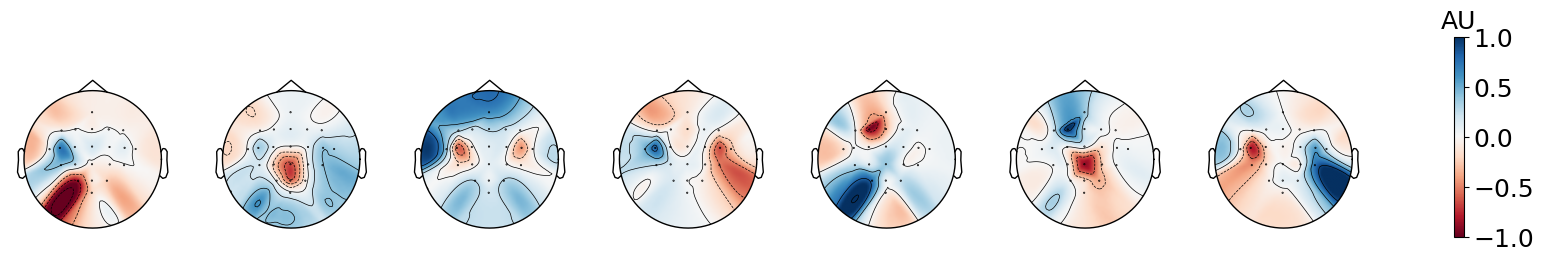

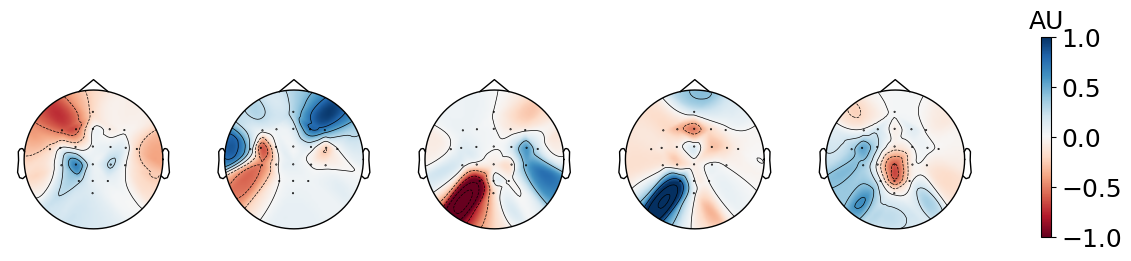

In [185]:
# visulize the pattern state activation patterns
all_state_space.plot_state_activation_patterns(np.reshape(X_features, (-1, X_features.shape[-1])), X_epoch_covs, list(ch_map.keys()))
task_state_space.plot_state_activation_patterns(np.reshape(X_task_features, (-1, X_task_features.shape[-1])), X_task_covs, list(ch_map.keys()))

In [186]:
# create Markov State Transition Matrix for each task
ytask = y[y != 0]
labels = np.unique(ytask)
models = [None] * len(labels)
for i, label in enumerate(labels):
    Xlabel = X_task_features[ytask == label]
    S = task_state_space.transform(Xlabel)
    print(S.shape)
    models[i] = ms.Markov_Model(task_state_space).fit(np.reshape(S, (-1, Nepochs)), verbose=True)

(260,)
Transition matrix:
[[0.26942308 0.17807692 0.17807692 0.19634615 0.17807692]
 [0.02397059 0.63867647 0.19860294 0.07985294 0.05889706]
 [0.12692308 0.05384615 0.60192308 0.16346154 0.05384615]
 [0.17076923 0.18903846 0.17076923 0.29865385 0.17076923]
 [0.17076923 0.20730769 0.24384615 0.17076923 0.20730769]]
(585,)
Transition matrix:
[[0.32017094 0.14153846 0.2308547  0.17401709 0.1334188 ]
 [0.02496063 0.61590551 0.2119685  0.07732283 0.06984252]
 [0.08460733 0.11942408 0.60188482 0.06471204 0.12937173]
 [0.1691453  0.1691453  0.21786325 0.29905983 0.14478632]
 [0.11068376 0.24871795 0.24059829 0.1025641  0.2974359 ]]
(610,)
Transition matrix:
[[0.26852459 0.16729508 0.21401639 0.19065574 0.1595082 ]
 [0.11901639 0.37598361 0.1657377  0.15016393 0.18909836]
 [0.13303279 0.11745902 0.46786885 0.1252459  0.15639344]
 [0.10188525 0.10188525 0.13303279 0.49901639 0.16418033]
 [0.02659389 0.08882096 0.10956332 0.07222707 0.70279476]]
(625,)
Transition matrix:
[[0.66983264 0.02987448

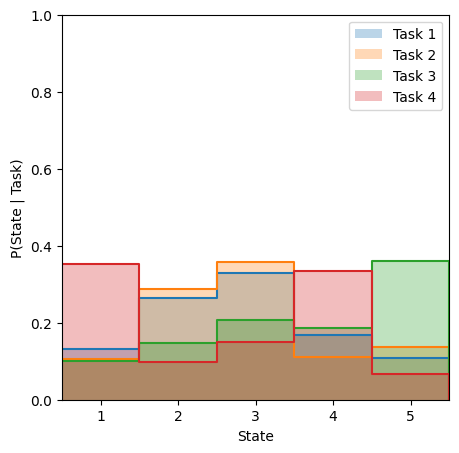

0.24960785153329132


In [187]:
# compute the taskDistinct
td = ms.task_distinct(models, visualize=True)
print(td)

In [188]:
# create a Markov State Transition Matrix for all tasks and rest
models = [None] * (len(labels) + 1)
for i, label in enumerate(labels):
    Xlabel = X_features[y == label]
    S = all_state_space.transform(Xlabel)
    models[i] = ms.Markov_Model(all_state_space).fit(np.reshape(S, (-1, Nepochs)), verbose=True)
S = all_state_space.transform(X_features[y == 0])
models[-1] = ms.Markov_Model(all_state_space).fit(np.reshape(S, (-1, Nepochs)), verbose=True)

Transition matrix:
[[0.44978022 0.11728022 0.06612637 0.0917033  0.11728022 0.0917033
  0.06612637]
 [0.15381868 0.20497253 0.12824176 0.12824176 0.12824176 0.12824176
  0.12824176]
 [0.06929239 0.02489987 0.53985314 0.22022697 0.03377837 0.03377837
  0.07817089]
 [0.19714286 0.07047619 0.11269841 0.40825397 0.15492063 0.02825397
  0.02825397]
 [0.1392033  0.11362637 0.11362637 0.11362637 0.29266484 0.11362637
  0.11362637]
 [0.16112637 0.10997253 0.13554945 0.10997253 0.13554945 0.23785714
  0.10997253]
 [0.16843407 0.11728022 0.0917033  0.11728022 0.0917033  0.11728022
  0.29631868]]
Transition matrix:
[[0.56648865 0.10480641 0.02489987 0.0870494  0.11368491 0.06041389
  0.04265688]
 [0.16884005 0.36208791 0.05516484 0.18020757 0.06653236 0.06653236
  0.10063492]
 [0.07140415 0.06003663 0.32148962 0.26465201 0.08277167 0.08277167
  0.11687424]
 [0.1201221  0.10875458 0.1201221  0.42704518 0.09738706 0.06328449
  0.06328449]
 [0.14123321 0.09576313 0.07302808 0.11849817 0.31174603 0.1

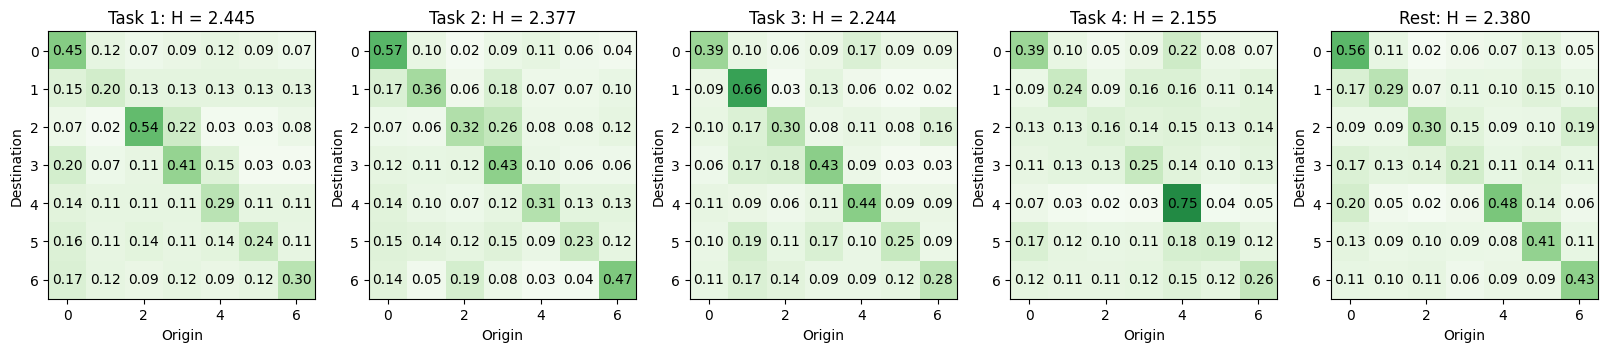

0.9777704526983638


In [189]:
# Compute relativeTaskInconsistency
rel_task_incon = ms.relative_task_inconsistency(models[:-1], models[-1], visualize=True)
print(rel_task_incon)